In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import skimage

from PIL import Image
import matplotlib.pyplot as plt
import torchvision.models as models
import copy
import pdb

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# dataloader and processing

In [ ]:
class styleTransferDataset(td.Dataset):
    def __init__(self, root_dir, mode='train', image_size=(512,512)):
        super(styleTransferDataset, self).__init__()
        self.mode = mode
        self.image_size = image_size
        self.images_dir = os.path.join(root_dir, mode)
        self.files = os.listdir(self.images_dir)
    
    def __len__(self):
        return len(self.files)

    def __repr__(self):
        return "StyleDataset(mode={}, image_size={}, sigma={})".format(self.mode, self.image_size)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.files[idx])
        img = Image.open(img_path).convert('RGB')
        np_img = np.array(img, dtype=np.float32)
        print(np_img.shape)
        np_img = np.transpose(np_img, axes=(2,0,1))
        print(np_img.shape)
        np_img = skimage.transform.resize(np_img, (3, self.image_size[0], self.image_size[1]), anti_aliasing=True)
        print(np_img.shape)
        np_img /= 255
        tensor_img = torch.from_numpy(np_img).to(device, torch.float32)
        print(tensor_img.shape)
        return tensor_img

In [4]:
def load_image(img_path):
    img = Image.open(img_path)
    np_img = np.array(img, dtype=np.float32)
    np_img = np.transpose(np_img, axes=(2,0,1))
    tensor_img = preprocess(np_img)

    return tensor_img

In [5]:
def preprocess(np_img):

    # resize to 512
    np_img = skimage.transform.resize(np_img, (3, 512, 512), anti_aliasing=True)
    # norm to 0-1
    np_img /= 255
    # to tensor
    tensor_img = torch.from_numpy(np_img).unsqueeze(0).to(device, torch.float32)
    # normalize with mean and std

    return tensor_img

In [56]:
def tensor_2_PIL(tensor_img):
    
    np_img = tensor_img.data.cpu().numpy() * 255
    np_img = np_img.astype(np.uint8)
    np_img = np.transpose(np_img, axes=(1,2,0))
    PIL_img = Image.fromarray(np_img)

    return PIL_img

In [6]:
def img_show(tensor_content_img, tensor_generate_img, tensor_style_img):
    PIL_content_img = tensor_2_PIL(tensor_content_img[0, :, :, :])
    PIL_generate_img = tensor_2_PIL(tensor_generate_img[0, :, :, :])
    PIL_style_img = tensor_2_PIL(tensor_style_img[0, :, :, :])

    ax = plt.subplot(1,3,1)
    ax.set_title('content image')
    ax.imshow(PIL_content_img)

    ax = plt.subplot(1,3,2)
    ax.set_title('transferd image')
    ax.imshow(PIL_generate_img)

    ax = plt.subplot(1,3,3)
    ax.set_title('style image')
    ax.imshow(PIL_style_img)

    plt.show()

# loss and normalization

In [7]:
class ContentLoss(nn.Module):

    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [8]:
def gram_matrix(input):
    n, c, h, w = input.shape

    features = input.view(n * c, h * w) 

    G = torch.mm(features, features.t())

    return G.div(n * c * h * w)


In [9]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input


In [10]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std


# model

In [11]:
def get_style_model_and_losses(net, style_img, content_img, style_layers, content_layers):

    net = copy.deepcopy(net)
    

    content_losses = []
    style_losses = []
    
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    model = nn.Sequential(normalization)

    content_losses = []
    style_losses = []

    i = 0
    for layer in net.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(label, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module('content_loss_{}'.format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module('style_loss_{}'.format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) -1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i+1)]

    return model, style_losses, content_losses


In [12]:
def style_transfer(input_img, tensor_style, tensor_content, total_steps=300, style_weight=1000000, content_weight=1):

    content_layers = ['conv_4']
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']


    net = models.vgg19(pretrained=True).features.to(device).eval()

    model, style_losses, content_losses = get_style_model_and_losses(net, tensor_style, tensor_content, style_layers=style_layers, content_layers=content_layers)

    optimizer = optim.LBFGS([input_img.requires_grad_()])

    step = [0]
    while step[0] <= total_steps:
        
        def closure():
            input_img.data.clamp_(0, 1)
            
            optimizer.zero_grad()
            
            total_style_loss = 0
            total_content_loss = 0
        
            #img_show(tensor_content, input_img, tensor_style)
          
            model(input_img)

            for sl in style_losses:
                total_style_loss += sl.loss
                #print('style_loss', sl.loss)
            for cl in content_losses:
                total_content_loss += cl.loss
                #print('content_loss', cl.loss)
            
            total_style_loss *= style_weight
            total_content_loss *= content_weight

            loss = total_style_loss + total_content_loss
            loss.backward()
            
            step[0] += 1
            if step[0] % 10 == 0:
                print('Step [{}], style_loss {:4f}, content_loss {:4f}'.format(step[0], total_style_loss.item(), total_content_loss.item()))
            
            return total_style_loss + total_content_loss

        optimizer.step(closure)


    input_img.data.clamp_(0, 1)
    return input_img

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Step [10], style_loss 14856.725586, content_loss 36.704361
Step [20], style_loss 1334.899048, content_loss 35.764797
Step [30], style_loss 598.678894, content_loss 36.308731
Step [40], style_loss 313.841064, content_loss 36.019886
Step [50], style_loss 229.035172, content_loss 35.768795
Step [60], style_loss 175.789566, content_loss 35.318901
Step [70], style_loss 136.803757, content_loss 35.140934
Step [80], style_loss 110.290833, content_loss 34.843437
Step [90], style_loss 87.513428, content_loss 34.468159
Step [100], style_loss 69.511612, content_loss 34.042042
Step [110], style_loss 58.303032, content_loss 33.692818
Step [120], style_loss 45.385986, content_loss 33.124149
Step [130], style_loss 36.731815, content_loss 32.550648
Step [140], style_loss 32.178474, content_loss 31.829153
Step [150], style_loss 26.068081, content_loss 31.262774
Step [160], style_loss 22.099407, content_loss 30.587297
Step [170], style_loss 18.545040, content_loss 29.822525
Step [180], style_loss 15.827

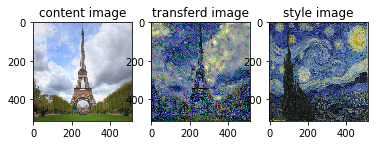

In [57]:
style_img = 'style.jpg'
content_img = 'content.jpg'

tensor_style = load_image(style_img)
tensor_content = load_image(content_img)

input_img = tensor_content.clone()

output = style_transfer(input_img, tensor_style, tensor_content)
img_show(tensor_content, output, tensor_style)